# Naive Bayes (the easy way)

We'll start by using Naive Bayes for the sort of problem it's best suited for: building a spam classifier! Most of the code is just loading our training data into a pandas DataFrame that we can play with:

In [1]:
import os
import io
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def readFiles(path):
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root, filename)

            inBody = False
            lines = []
            f = io.open(path, 'r', encoding='latin1')
            for line in f:
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            message = '\n'.join(lines)
            yield path, message


def dataFrameFromDirectory(path, classification):
    rows = []
    index = []
    for filename, message in readFiles(path):
        rows.append({'message': message, 'class': classification})
        index.append(filename)

    return DataFrame(rows, index=index)

data = DataFrame({'message': [], 'class': []})

data = data.append(dataFrameFromDirectory('emails/spam', 'spam'))
data = data.append(dataFrameFromDirectory('emails/ham', 'ham'))


E:\Anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Let's have a look at that DataFrame:

In [2]:
data.head()

,class,message
emails/spam\00001.7848dde101aa985090474a91ec93fcf0,spam,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
emails/spam\00002.d94f1b97e48ed3b553b3508d116e6a09,spam,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
emails/spam\00003.2ee33bc6eacdb11f38d052c44819ba6c,spam,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
emails/spam\00004.eac8de8d759b7e74154f142194282724,spam,##############################################...
emails/spam\00005.57696a39d7d84318ce497886896bf90d,spam,I thought you might like these:\n\n1) Slim Dow...


Now we will use a CountVectorizer to split up each message into its list of words, and throw that into a MultinomialNB classifier. Call fit() and we've got a trained spam filter ready to go! It's just that easy.

In [3]:
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(data['message'].values)

classifier = MultinomialNB()
targets = data['class'].values
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Let's try it out:

In [4]:
examples = ['Free Viagra now!!!', "Hi Bob, how about a game of golf tomorrow?"]
example_counts = vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
predictions

array(['spam', 'ham'], dtype='<U4')

That's pretty cool; we have a simple yet somewhat effective spam filter!

Now let's see how well Naive Bayes works on our problem of predicting vehicle speed classifications (slow or fast) based on the size and distance to an upcoming bump in the road. Again, we'll fabricate our data set exactly as we did before:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs

n_samples = 10000

# To generate our fabricated data set, we'll create two blobs of
# randomly distributed data at two corners of the graph...
centers = [(0.9, 0.05), (0.05, 0.94)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.4,
                  centers=centers, shuffle=False, random_state=42)

# Then filter out only the values that lie within [0,1]:
features = []
labels = []
for feature, label in zip(X, y):
    if (feature[0] >= 0 and feature[0] <= 1.0 and feature[1] >= 0 and feature[1] <= 1.0):
        features.append(feature)
        labels.append(label)

# And convert the results back into numpy arrays:
X = np.array(features)
y = np.array(labels)

Now let's create a Multinomial Naive Bayes classifier model, fit it to our data, and visualize the results:

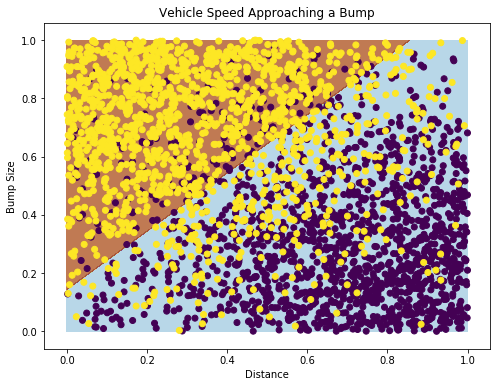

In [6]:
clf = MultinomialNB()
clf.fit(X, y)

def plotPredictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 1.0, 0.001),
                     np.arange(0, 1.0, 0.001))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 6))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
    plt.xlabel('Distance')
    plt.ylabel('Bump Size')
    plt.title("Vehicle Speed Approaching a Bump")
    plt.show()
    
plotPredictions(clf)

It seems to have found just about the same linear relationship that our logistic regression model found. Data set that have simple patterns are usually best served with simpler models, it turns out. So while you could use Naive Bayes for this problem, it may be a bit of overkill. Let's measure its accuracy:

In [7]:
from sklearn.model_selection import cross_val_score

fold_scores = cross_val_score(clf, X, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.85245902 0.8295082  0.83251232 0.82758621 0.81773399]
0.831959945086005


Interestingly, logistic regression actually out-performs it slightly. But the results are still decent, and close enough to logistic regression's results that there may not be a real difference.

## Activity

Our data set is small, so our spam classifier isn't actually very good. Try running some different test emails through it and see if you get the results you expect.

If you really want to challenge yourself, try applying train/test to this spam classifier - see how well it can predict some subset of the ham and spam emails.